# OutOfSampleCausalTuning

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from lingam import DirectLiNGAM
from lingam.utils import make_dot

from lingam.experimental import OutOfSampleCausalTuning

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

## Test data

First we create simple structural data.

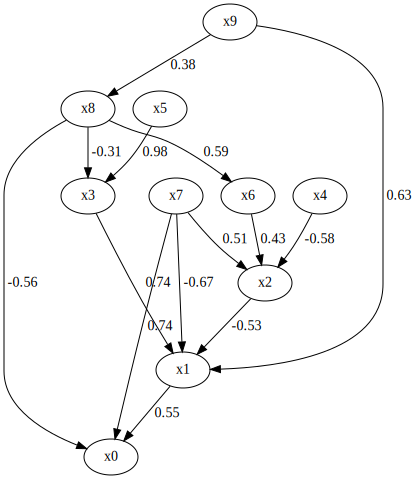

(1000, 10)

In [2]:
node_num = 10
sample_num = 1000

# make graph
graph = np.random.choice([0, 1], p=[0.8, 0.2], size=(node_num, node_num))
graph = np.triu(graph, k=1)

# force to have child nodes
for i in range(1, node_num):
    if np.sum(graph[:, i]) == 0:
        pos = np.random.choice(range(0, i))
        graph[pos, i] = 1

# coefficients
graph = graph * np.random.uniform(0.2, 1.0, size=graph.shape) * np.random.choice([-1, 1], size=graph.shape)

display(make_dot(graph))

# generate data
X = np.zeros((sample_num, graph.shape[0]))
for i in reversed(range(graph.shape[0])):
    X[:, i] = graph[i] @ X.T + np.random.uniform(0, 1, size=1000)

X = pd.DataFrame(X, columns=[f"x{i}" for i in range(node_num)])
X.shape

## Preparation of configurations

We prepare two configurations. Each configuration contains a specification of the algorithm for causal discovery and the second configuration contains a keyword argument of the constructor of the causal discovery. We set a prior knowledge to prevent a graph from having edges where it should have edges.

In [3]:
configs = [
    {
        "model": DirectLiNGAM
    },
    {
        "model": DirectLiNGAM,
        "init_kwargs": {
            "prior_knowledge": graph.astype(bool) - 1
        }
    },
]

## Initialization

Initialization can take two main arguments. `cv` specifies the number of folds and `thr` specifies a threshold of the permutation test in the sparsity penalty.

In [4]:
model = OutOfSampleCausalTuning(cv=10, thr=0.05)

## Run

In [5]:
model.fit(X, configs)

The result is stored in `best_config_index_`.

In [6]:
print(model.best_config_index_)

0


The result is 0 as we expected.

## More information about the result

Information in fit() is stored in `scores_`. 

`performace` stores scores of given configurations. `mb_size` stores the average markov blanket size for each configuration. `sp_score` stores the sparsity penalty score in dictionary form and its key is the index of the configuration and its values is the score of the configuration. The configurations with the best scores are not in `sp_score`.

In [7]:
display(model.scores_)

{'performance': [0.33200601511826255, 0.3291841177861622],
 'mb_size': [6.32, 8.66],
 'sp_score': {1: 0.0}}